# Outline of final set-up
- Visualization of simple arrays for proof of concept
- Do everything for 10^3 to have something on the page

I think tarjan is the source of my stack overflow problems. Unhelpfully, python notebooks just kill their kernel without tellig you what's happening.

Here's the error code:
```
Fatal Python error: Cannot recover from stack overflow.

Current thread 0x00007fff78a8b000 (most recent call first):
  File "/Users/moranse/Documents/02-Academics/computational-physics-F17/03_Project/code/tools.py", line 45 in calc_component
  ...
  Abort trap: 6
```


# To-do
- This should mostly work now-- can run up to 1e4 nodes successfully on my laptop
- Switching to numpy arrays broke everything-- get everything working again when back on internet
    - Use the edge density calculations used in prior versions of this notebook 
- Once that's finished, go through and see if I can switch the edge density and get interesting results that way

In [6]:
# Auto-reloads external files so I can stop re-loading
%load_ext autoreload
%autoreload 2

%matplotlib inline
from tools import *
import graphs as g
import figs as f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


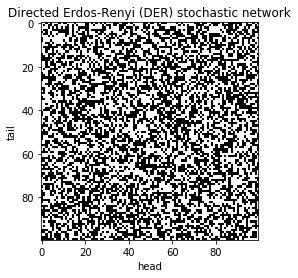

In [12]:
n = int(1e2)
edge_density = 50

DER_viz = g.Graph(n,edge_density*n,'DER')
DER_viz.build()
plt.imshow((DER_viz.edges>0),cmap='binary')
plt.title('Directed Erdos-Renyi (DER) network')
plt.ylabel('tail')
plt.xlabel('head')
# plt.colorbar()
plt.show()

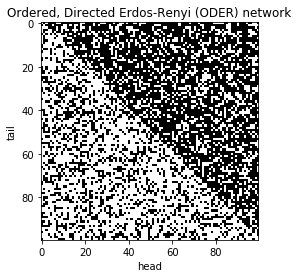

In [13]:
ODER_viz = g.Graph(n,edge_density*n,'ODER')
ODER_viz.build()
plt.imshow((ODER_viz.edges>0),cmap='binary')
plt.title('Ordered, Directed Erdos-Renyi (ODER) network')
plt.ylabel('tail')
plt.xlabel('head')
# plt.colorbar()
plt.show()

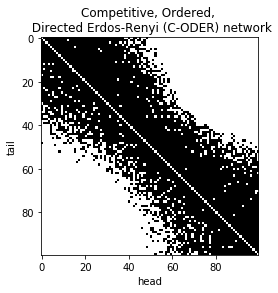

In [14]:
CODER_viz = g.Graph(n,edge_density*n,'C-ODER')
CODER_viz.build()
plt.imshow((CODER_viz.edges>0),cmap='binary')
plt.title('Competitive, Ordered, \n Directed Erdos-Renyi (C-ODER) network')
plt.ylabel('tail')
plt.xlabel('head')
# plt.colorbar()
plt.show()

# Replicating figures from the paper

See notes for metrics.
- $\phi = \frac{50}{10^6} = 5E-5 = $ fraction of a system that an average node reaches 
- $m_0=$ average number of edges per node

We are better off studying a range of $\phi=\frac{m_0}{n}$, as this is more analogous to $p_c$ in percolation lattices.

As before, $n$ is the total number of nodes and $m$ is the total number of edges.

So our range of behaviors is:
- Lower bound: $m_0=1$, $n=2E4$, $m=2E4$
- Upper bound (paper): $m_0=50$, $n=1E6$, $m=50E6$
- General case: $m_0$, $n=\frac{m_0}{\phi}$, $m=m_0{\cdot}n$

In all cases, `edge_density` as defined in the paper is $\frac{m}{n}$== so just $m_0$.

In the paper, when they change the `edge_density`, what they are actually changing is the fraction of the system that any given node is connected to.

## Fig 5&6

I'm able to replicate the shape of these results, my "edge densities" are off by a factor of $\approx 5$. It's not clear to me why this is.

The equivalent density at these system sizes is much lower. If anything, I'm actually getting a much higher critical density than I should!

In [ ]:
# Plot ODER - might have to run outside of a jupyter notebook to get n-10^5 or higher
# Running outside of a jupyter notebook still does not solve the problem -- then I run into memory issuees

# actual settings in the experiment
# n = int(1e6)
# phi = np.linspace(1e-6,5e-5,5)

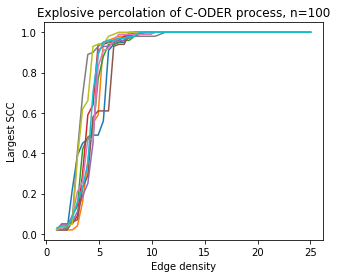

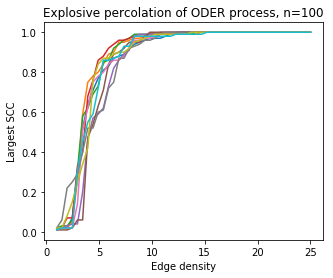

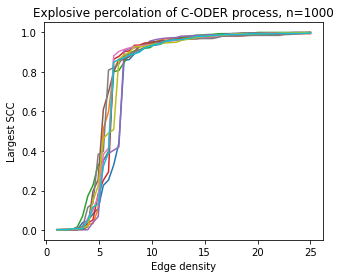

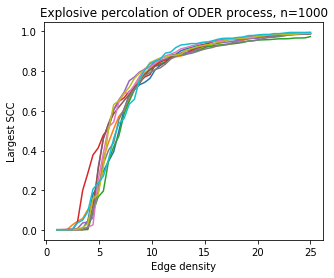

In [19]:
edge_densities = np.linspace(1,25,50)
replicates = 10

n = int(1e2)
# f.figure56('DER',n,edge_densities,replicates)
f.figure56('C-ODER',n,edge_densities,replicates)
f.figure56('ODER',n,edge_densities,replicates)

n = int(1e3)
f.figure56('C-ODER',n,edge_densities,replicates)
f.figure56('ODER',n,edge_densities,replicates)

## Figures stored in comments in this cell
[//]: # "![fig5](figs/fig5.png)"
[//]: # "![fig6](figs/fig6.png)"

## Figure 7

Again, in the paper they simulate up to $10^6$ nodes, which is just wildly large. They really didn't need to do this...? Also, what edge density did they use? They don't say. I'm assuming it's 50, because I don't get the same results for other values.

![fig7](figs/fig7.png)

In [ ]:
'''
Paper did:
edge_density = 50
systems = np.linspace(1e5,1e6,7).astype(int)
'''

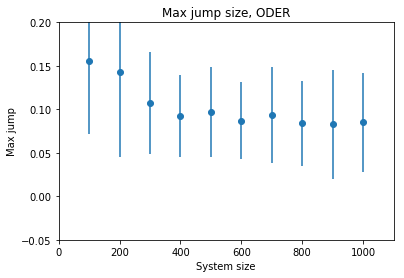

In [ ]:
edge_density = 50
systems = np.linspace(1e2,1e3,10).astype(int)
replicates = 40
f.figure7('ODER',systems,edge_density,replicates)

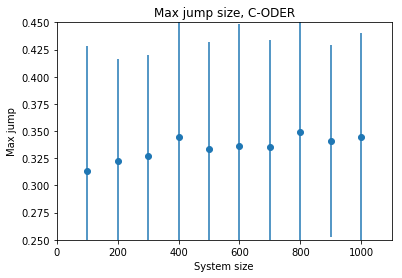

In [11]:
edge_density = 50
systems = np.linspace(1e2,1e3,10).astype(int)
replicates = 40
f.figure7('C-ODER',systems,edge_density,replicates)

## Figure 8

Again, this spot-on replicates the finding that the C-ODER process jump comes from the combination of two large components combining-- but the critical edge density is off by a factor of 5! 

![fig8](figs/fig8.png)

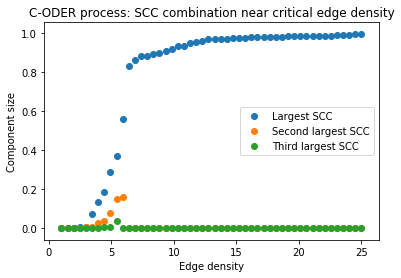

In [4]:
edge_densities = np.linspace(1,25,50)
n = int(1e3)
f.figure8('C-ODER',n,edge_densities)

## Figure 9
Interesting, but low priority until other issues are worked out.

![fig9](figs/fig9.png)